In [1]:
import os, cv2, yaml, torch, numpy as np, matplotlib.pyplot as plt
from torchvision.models import resnet18
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
paths = {
    "video_root": "data/videos",
    "segments_csv": "data/annotations_segments.csv",
    "features_train": "outputs/features/train/",
    "features_val": "outputs/features/val/",
    "labels_train": "outputs/labels/train/",
    "labels_val": "outputs/labels/val/",
    "models": "outputs/models/"
}
os.makedirs(paths["features_train"], exist_ok=True)
os.makedirs(paths["features_val"], exist_ok=True)
os.makedirs(paths["labels_train"], exist_ok=True)
os.makedirs(paths["labels_val"], exist_ok=True)
os.makedirs(paths["models"], exist_ok=True)

# Dataset info
NUM_CLASSES = 10
FRAME_STEP = 2       # sample every 2nd frame

In [4]:
model = resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # remove FC layer
model.to(device).eval()

transform = transforms.Compose([
    transforms.ToTensor(),              # converts numpy → tensor
    transforms.Resize((224,224)),       # works on tensors in recent torchvision
    transforms.Normalize(mean=[0.45]*3, std=[0.225]*3)
])


def extract_video_features(video_path, out_path, step=FRAME_STEP):
    cap = cv2.VideoCapture(str(video_path))
    feats = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = transform(frame).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(frame).squeeze().cpu().numpy()   # [512]
        feats.append(feat)
        for _ in range(step-1): cap.grab()
    cap.release()
    np.save(out_path, np.stack(feats))

# Example extraction for one video (train or val)
# sample_video = os.listdir(paths["video_root"])[0]
# extract_video_features(os.path.join(paths["video_root"], sample_video),
#                        os.path.join(paths["features_train"], sample_video.replace(".mp4",".npy")))


In [26]:
import pandas as pd

segments = pd.read_csv(paths["segments_csv"])

def generate_labels_for_video(video_id, out_path, fps_sample=25//FRAME_STEP):
    segs = segments[segments["VideoID"]==video_id]
    total = int(segs["End"].max()/FRAME_STEP)
    labels = np.zeros(total, dtype=np.int32)
    for _, row in segs.iterrows():
        s, e, pid = int(row["Start"]/FRAME_STEP), int(row["End"]/FRAME_STEP), int(row["PhaseID"])
        labels[s:e] = pid-1
        # print(labels)
    np.save(out_path, labels)

for vid in segments["VideoID"].unique():
    split = "train" if vid%5!=0 else "val"     # 80/20 split
    out_dir = paths["labels_train"] if split=="train" else paths["labels_val"]
    generate_labels_for_video(vid, os.path.join(out_dir, f"case_{vid:03d}.npy"))

print("Done ✅")

Done ✅


In [8]:
for vid in segments["VideoID"].unique():
    if vid > 739:
        print(f"case_{vid:03d}")
        split = "train" if vid%5!=0 else "val"     # 80/20 split
        out_dir = paths["features_train"] if split=="train" else paths["features_val"]
        extract_video_features(os.path.join(paths["video_root"], f"case_{vid:03d}.mp4"),
                           os.path.join(out_dir, f"case_{vid:03d}.npy"))
        print(f"case_{vid:03d} Done ✅")
    else:
        continue
print("Done ✅")

case_745
case_745 Done ✅
case_749
case_749 Done ✅
case_750
case_750 Done ✅
case_751
case_751 Done ✅
case_760
case_760 Done ✅
case_764
case_764 Done ✅
case_768
case_768 Done ✅
case_770
case_770 Done ✅
case_771
case_771 Done ✅
case_778
case_778 Done ✅
case_781
case_781 Done ✅
case_784
case_784 Done ✅
case_785
case_785 Done ✅
case_786
case_786 Done ✅
case_788
case_788 Done ✅
case_796
case_796 Done ✅
case_797
case_797 Done ✅
case_799
case_799 Done ✅
case_801
case_801 Done ✅
case_802
case_802 Done ✅
case_804
case_804 Done ✅
case_806
case_806 Done ✅
case_807
case_807 Done ✅
case_808
case_808 Done ✅
case_809
case_809 Done ✅
case_810
case_810 Done ✅
case_817
case_817 Done ✅
case_821
case_821 Done ✅
case_825
case_825 Done ✅
case_827
case_827 Done ✅
case_828
case_828 Done ✅
case_829
case_829 Done ✅
case_830
case_830 Done ✅
case_834
case_834 Done ✅
case_835
case_835 Done ✅
case_840
case_840 Done ✅
case_841
case_841 Done ✅
case_845
case_845 Done ✅
case_846
case_846 Done ✅
case_847
case_847 Done ✅


In [5]:
import torch

if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(f"🟢 CUDA is available! {num_devices} GPU(s) detected.\n")
    for i in range(num_devices):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
else:
    print("🔴 CUDA is not available.")


🟢 CUDA is available! 1 GPU(s) detected.

Device 0: NVIDIA A100-SXM4-40GB
  Memory: 39.38 GB


In [6]:
class DilatedResidualLayer(nn.Module):
    def __init__(self, in_channels, dilation):
        super().__init__()
        self.conv_dil = nn.Conv1d(in_channels, in_channels, 3,
                                  padding=dilation, dilation=dilation)
        self.conv_1x1 = nn.Conv1d(in_channels, in_channels, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.conv_dil(x)
        out = self.relu(out)
        out = self.conv_1x1(out)
        return out + x

class ASFormer(nn.Module):
    def __init__(self, in_dim=512, num_classes=NUM_CLASSES,
                 d_model=256, n_heads=4, n_blocks=2):
        super().__init__()
        self.input_proj = nn.Conv1d(in_dim, d_model, 1)
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=2*d_model, dropout=0.1,
            activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, num_layers=n_blocks)
        self.residuals = nn.Sequential(
            DilatedResidualLayer(d_model,1),
            DilatedResidualLayer(d_model,2),
            DilatedResidualLayer(d_model,4)
        )
        self.classifier = nn.Conv1d(d_model, num_classes, 1)
    def forward(self, x):   # [B,C,T]
        x = x.transpose(1,2)
        x = self.input_proj(x.transpose(1,2)).transpose(1,2)
        x = self.transformer(x)
        x = x.transpose(1,2)
        x = self.residuals(x)
        return self.classifier(x)

print("Done ✅")

Done ✅


In [7]:
class FeatureDataset(Dataset):
    def __init__(self, feat_dir, label_dir):
        self.videos = sorted(os.listdir(feat_dir))
        self.feat_dir, self.label_dir = feat_dir, label_dir
    def __len__(self): return len(self.videos)
    def __getitem__(self, idx):
        name = self.videos[idx]
        x = np.load(os.path.join(self.feat_dir, name))  # [T,512]
        y = np.load(os.path.join(self.label_dir, name)) # [T]
        x = torch.tensor(x.T, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y

train_ds = FeatureDataset(paths["features_train"], paths["labels_train"])
val_ds   = FeatureDataset(paths["features_val"],   paths["labels_val"])
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False)

print("Done ✅")

Done ✅


In [8]:
model = ASFormer(in_dim=512).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

best_loss = np.inf
for epoch in range(25):
    model.train()
    losses = []
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        yhat = model(X)
        T = min(yhat.shape[-1], y.shape[-1])
        yhat = yhat[:, :, :T]
        y = y[:, :T]
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    val_loss = np.mean(losses)
    print(f"Epoch {epoch+1:02d} | train_loss={val_loss:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(paths["models"], "asformer_best.pth"))

print("Done ✅")

Epoch 1: 100% 78/78 [00:07<00:00, 10.70it/s]


Epoch 01 | train_loss=0.3091


Epoch 2: 100% 78/78 [00:03<00:00, 20.19it/s]


Epoch 02 | train_loss=0.2164


Epoch 3: 100% 78/78 [00:03<00:00, 20.47it/s]


Epoch 03 | train_loss=0.1906


Epoch 4: 100% 78/78 [00:04<00:00, 18.39it/s]


Epoch 04 | train_loss=0.1738


Epoch 5: 100% 78/78 [00:03<00:00, 20.37it/s]


Epoch 05 | train_loss=0.1471


Epoch 6: 100% 78/78 [00:03<00:00, 20.03it/s]


Epoch 06 | train_loss=0.1342


Epoch 7: 100% 78/78 [00:03<00:00, 20.31it/s]


Epoch 07 | train_loss=0.1220


Epoch 8: 100% 78/78 [00:03<00:00, 20.02it/s]


Epoch 08 | train_loss=0.1045


Epoch 9: 100% 78/78 [00:03<00:00, 19.98it/s]


Epoch 09 | train_loss=0.1038


Epoch 10: 100% 78/78 [00:03<00:00, 20.80it/s]


Epoch 10 | train_loss=0.0794


Epoch 11: 100% 78/78 [00:03<00:00, 20.77it/s]


Epoch 11 | train_loss=0.0760


Epoch 12: 100% 78/78 [00:03<00:00, 21.03it/s]


Epoch 12 | train_loss=0.0726


Epoch 13: 100% 78/78 [00:03<00:00, 19.68it/s]


Epoch 13 | train_loss=0.0590


Epoch 14: 100% 78/78 [00:04<00:00, 19.02it/s]


Epoch 14 | train_loss=0.0685


Epoch 15: 100% 78/78 [00:04<00:00, 18.26it/s]


Epoch 15 | train_loss=0.0774


Epoch 16: 100% 78/78 [00:04<00:00, 19.01it/s]


Epoch 16 | train_loss=0.0551


Epoch 17: 100% 78/78 [00:04<00:00, 19.43it/s]


Epoch 17 | train_loss=0.0512


Epoch 18: 100% 78/78 [00:03<00:00, 20.56it/s]


Epoch 18 | train_loss=0.0461


Epoch 19: 100% 78/78 [00:03<00:00, 20.46it/s]


Epoch 19 | train_loss=0.0506


Epoch 20: 100% 78/78 [00:03<00:00, 20.29it/s]


Epoch 20 | train_loss=0.0466


Epoch 21: 100% 78/78 [00:04<00:00, 19.23it/s]


Epoch 21 | train_loss=0.0340


Epoch 22: 100% 78/78 [00:03<00:00, 20.84it/s]


Epoch 22 | train_loss=0.0360


Epoch 23: 100% 78/78 [00:03<00:00, 19.68it/s]


Epoch 23 | train_loss=0.0333


Epoch 24: 100% 78/78 [00:03<00:00, 19.54it/s]


Epoch 24 | train_loss=0.0275


Epoch 25: 100% 78/78 [00:04<00:00, 18.45it/s]

Epoch 25 | train_loss=0.0328
Done ✅


In [9]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn

model = ASFormer(in_dim=512, num_classes=10).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

best_loss = np.inf

def accuracy(yhat, y):
    """Compute frame-wise accuracy."""
    preds = torch.argmax(yhat, dim=1)      # [B, T]
    correct = (preds == y).float().sum()
    total = torch.numel(y)
    return (correct / total).item()

for epoch in range(25):
    # -------------------- TRAIN --------------------
    model.train()
    tr_losses, tr_accs = [], []

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        yhat = model(X)            # [B, C, T]
        T = min(yhat.shape[-1], y.shape[-1])
        yhat, y = yhat[:, :, :T], y[:, :T]

        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()

        tr_losses.append(loss.item())
        tr_accs.append(accuracy(yhat, y))

    tr_loss = np.mean(tr_losses)
    tr_acc = np.mean(tr_accs)

    # -------------------- VALIDATION --------------------
    model.eval()
    val_losses, val_accs = [], []

    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            T = min(yhat.shape[-1], y.shape[-1])
            yhat, y = yhat[:, :, :T], y[:, :T]

            val_losses.append(criterion(yhat, y).item())
            val_accs.append(accuracy(yhat, y))

    val_loss = np.mean(val_losses)
    val_acc = np.mean(val_accs)

    # -------------------- PRINT SUMMARY --------------------
    print(f"Epoch {epoch+1:02d} | "
          f"Train: loss={tr_loss:.3f}, acc={tr_acc:.3f} | "
          f"Val: loss={val_loss:.3f}, acc={val_acc:.3f}")

    # -------------------- SAVE BEST --------------------
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(paths["models"], "asformer_best.pth"))

print("Done ✅")


Epoch 1 [Train]: 100% 78/78 [00:04<00:00, 16.14it/s]
Epoch 1 [Val]: 100% 23/23 [00:01<00:00, 13.36it/s]


Epoch 01 | Train: loss=0.311, acc=0.936 | Val: loss=0.187, acc=0.960


Epoch 2 [Train]: 100% 78/78 [00:04<00:00, 16.58it/s]
Epoch 2 [Val]: 100% 23/23 [00:00<00:00, 40.86it/s]


Epoch 02 | Train: loss=0.218, acc=0.952 | Val: loss=0.196, acc=0.960


Epoch 3 [Train]: 100% 78/78 [00:04<00:00, 17.95it/s]
Epoch 3 [Val]: 100% 23/23 [00:00<00:00, 32.81it/s]


Epoch 03 | Train: loss=0.204, acc=0.952 | Val: loss=0.151, acc=0.960


Epoch 4 [Train]: 100% 78/78 [00:03<00:00, 19.86it/s]
Epoch 4 [Val]: 100% 23/23 [00:00<00:00, 36.87it/s]


Epoch 04 | Train: loss=0.175, acc=0.954 | Val: loss=0.139, acc=0.956


Epoch 5 [Train]: 100% 78/78 [00:03<00:00, 20.65it/s]
Epoch 5 [Val]: 100% 23/23 [00:00<00:00, 38.83it/s]


Epoch 05 | Train: loss=0.156, acc=0.956 | Val: loss=0.149, acc=0.961


Epoch 6 [Train]: 100% 78/78 [00:03<00:00, 19.84it/s]
Epoch 6 [Val]: 100% 23/23 [00:00<00:00, 40.36it/s]


Epoch 06 | Train: loss=0.136, acc=0.963 | Val: loss=0.180, acc=0.960


Epoch 7 [Train]: 100% 78/78 [00:04<00:00, 18.78it/s]
Epoch 7 [Val]: 100% 23/23 [00:00<00:00, 39.66it/s]


Epoch 07 | Train: loss=0.130, acc=0.961 | Val: loss=0.140, acc=0.960


Epoch 8 [Train]: 100% 78/78 [00:04<00:00, 19.39it/s]
Epoch 8 [Val]: 100% 23/23 [00:00<00:00, 37.14it/s]


Epoch 08 | Train: loss=0.109, acc=0.968 | Val: loss=0.126, acc=0.961


Epoch 9 [Train]: 100% 78/78 [00:04<00:00, 19.28it/s]
Epoch 9 [Val]: 100% 23/23 [00:00<00:00, 38.11it/s]


Epoch 09 | Train: loss=0.101, acc=0.968 | Val: loss=0.132, acc=0.962


Epoch 10 [Train]: 100% 78/78 [00:03<00:00, 20.75it/s]
Epoch 10 [Val]: 100% 23/23 [00:00<00:00, 31.87it/s]


Epoch 10 | Train: loss=0.076, acc=0.974 | Val: loss=0.149, acc=0.952


Epoch 11 [Train]: 100% 78/78 [00:04<00:00, 19.43it/s]
Epoch 11 [Val]: 100% 23/23 [00:00<00:00, 39.72it/s]


Epoch 11 | Train: loss=0.081, acc=0.970 | Val: loss=0.150, acc=0.957


Epoch 12 [Train]: 100% 78/78 [00:03<00:00, 20.65it/s]
Epoch 12 [Val]: 100% 23/23 [00:00<00:00, 39.16it/s]


Epoch 12 | Train: loss=0.072, acc=0.974 | Val: loss=0.146, acc=0.963


Epoch 13 [Train]: 100% 78/78 [00:03<00:00, 21.56it/s]
Epoch 13 [Val]: 100% 23/23 [00:00<00:00, 45.46it/s]


Epoch 13 | Train: loss=0.065, acc=0.978 | Val: loss=0.121, acc=0.966


Epoch 14 [Train]: 100% 78/78 [00:03<00:00, 19.85it/s]
Epoch 14 [Val]: 100% 23/23 [00:00<00:00, 38.80it/s]


Epoch 14 | Train: loss=0.057, acc=0.979 | Val: loss=0.123, acc=0.964


Epoch 15 [Train]: 100% 78/78 [00:03<00:00, 19.52it/s]
Epoch 15 [Val]: 100% 23/23 [00:00<00:00, 37.64it/s]


Epoch 15 | Train: loss=0.061, acc=0.978 | Val: loss=0.150, acc=0.963


Epoch 16 [Train]: 100% 78/78 [00:03<00:00, 20.02it/s]
Epoch 16 [Val]: 100% 23/23 [00:00<00:00, 39.99it/s]


Epoch 16 | Train: loss=0.058, acc=0.980 | Val: loss=0.161, acc=0.964


Epoch 17 [Train]: 100% 78/78 [00:03<00:00, 21.10it/s]
Epoch 17 [Val]: 100% 23/23 [00:00<00:00, 37.25it/s]


Epoch 17 | Train: loss=0.071, acc=0.978 | Val: loss=0.189, acc=0.952


Epoch 18 [Train]: 100% 78/78 [00:04<00:00, 19.36it/s]
Epoch 18 [Val]: 100% 23/23 [00:00<00:00, 45.63it/s]


Epoch 18 | Train: loss=0.071, acc=0.977 | Val: loss=0.161, acc=0.963


Epoch 19 [Train]: 100% 78/78 [00:03<00:00, 20.46it/s]
Epoch 19 [Val]: 100% 23/23 [00:00<00:00, 31.84it/s]


Epoch 19 | Train: loss=0.047, acc=0.983 | Val: loss=0.147, acc=0.965


Epoch 20 [Train]: 100% 78/78 [00:03<00:00, 20.66it/s]
Epoch 20 [Val]: 100% 23/23 [00:00<00:00, 43.23it/s]


Epoch 20 | Train: loss=0.039, acc=0.986 | Val: loss=0.140, acc=0.964


Epoch 21 [Train]: 100% 78/78 [00:03<00:00, 20.75it/s]
Epoch 21 [Val]: 100% 23/23 [00:00<00:00, 36.56it/s]


Epoch 21 | Train: loss=0.038, acc=0.986 | Val: loss=0.143, acc=0.968


Epoch 22 [Train]: 100% 78/78 [00:04<00:00, 18.79it/s]
Epoch 22 [Val]: 100% 23/23 [00:00<00:00, 29.37it/s]


Epoch 22 | Train: loss=0.038, acc=0.986 | Val: loss=0.148, acc=0.960


Epoch 23 [Train]: 100% 78/78 [00:04<00:00, 18.05it/s]
Epoch 23 [Val]: 100% 23/23 [00:00<00:00, 33.50it/s]


Epoch 23 | Train: loss=0.036, acc=0.987 | Val: loss=0.159, acc=0.964


Epoch 24 [Train]: 100% 78/78 [00:03<00:00, 20.33it/s]
Epoch 24 [Val]: 100% 23/23 [00:00<00:00, 42.94it/s]


Epoch 24 | Train: loss=0.034, acc=0.987 | Val: loss=0.175, acc=0.968


Epoch 25 [Train]: 100% 78/78 [00:03<00:00, 20.08it/s]
Epoch 25 [Val]: 100% 23/23 [00:00<00:00, 37.51it/s]

Epoch 25 | Train: loss=0.027, acc=0.990 | Val: loss=0.173, acc=0.966
Done ✅


In [11]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm

model.load_state_dict(torch.load(os.path.join(paths["models"], "asformer_best.pth")))
model.eval()

accs, f1s = [], []

for X, y in tqdm(val_loader, desc="Evaluating"):
    X = X.to(device)
    y = y.squeeze(0).cpu().numpy()                # ✅ flatten ground truth

    with torch.no_grad():
        pred = model(X).squeeze(0).cpu().numpy()  # [num_classes, T]
        pred = pred.argmax(0)                     # [T]

    T = min(len(pred), len(y))
    accs.append(accuracy_score(y[:T], pred[:T]))
    f1s.append(f1_score(y[:T], pred[:T], average='macro'))

print(f"\nMean Accuracy: {np.mean(accs):.3f}")
print(f"Mean F1-score: {np.mean(f1s):.3f}")

print("Done ✅")


Evaluating: 100% 23/23 [00:00<00:00, 30.63it/s]


Mean Accuracy: 0.966
Mean F1-score: 0.651
Done ✅


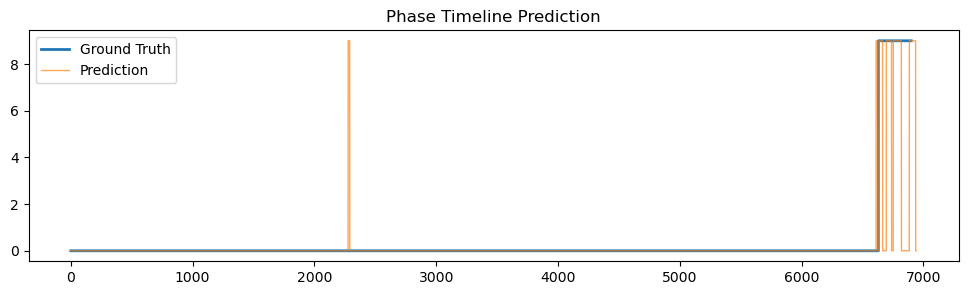

Done ✅


In [12]:
# visualize a random validation video prediction
idx = np.random.randint(len(val_ds))
X, y = val_ds[idx]
with torch.no_grad():
    pred = model(X.unsqueeze(0).to(device)).squeeze(0).cpu().numpy().argmax(0)

plt.figure(figsize=(12,3))
plt.plot(y, label='Ground Truth', lw=2)
plt.plot(pred, label='Prediction', lw=1, alpha=0.7)
plt.legend(); plt.title("Phase Timeline Prediction"); plt.show()

print("Done ✅")